### 2. Data Understanding

##### In this section, I will list the sources where the data can be found to support the analysis of the business problem we discussed in the previous section. And, I will take a look at the data to identify and understand the data a bit. Then I will move on to do wrangling the data to prepare that for extensive analysis.

##### Data Sources

1. Foursquare - is the major source of my analysis as it provides all the venues around the neighbourhoods. This source is capable of providing lot of additional information like ratings etc. but for this analysis, I will be focusing at the high level and using the appropriate level of data that can be obtained with a regular membership

2. Wiki - This is another lake of source. I will be using this to get the initial list such as zip/postal codes, boroughs etc.
    - Toronto Neighbourhood https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

3. Other sites - to get information like demographics etc.
    - NY City Zip https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/
    - NY Zipcode Mapping https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm

In [1]:
pip install lxml

     |████████████████████████████████| 5.8MB 30.5MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
#!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes

print('Folium installed')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    scipy-1.4.1                |   py36h921218d_0        18.9 MB  conda-forge
    libcblas-3.8.0             |      11_openblas          10 KB  conda-forge


In [3]:
#for word cloud
!conda install -c conda-forge wordcloud==1.4.1 --yes # install wordcloud

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py36_0 conda-forge


wordcloud-1.4.1      | 324 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Wordcloud is installed and imported!


In [4]:
import pandas as pd
import requests # library to handle requests
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # plotting library

#### New York Data

In [5]:
nyzipmap = pd.read_csv("NY City Zip Code Mapping.csv")

In [6]:
nyzipmap.shape

(42, 4)

In [7]:
nyzipmap.head()

,Borough,Neighbourhood,Zip,ZIP Codes
0,Bronx,Central Bronx,"10453, 10457, 10460",NaN
1,Bronx,Bronx Park and Fordham,"10458, 10467, 10468",NaN
2,Bronx,High Bridge and Morrisania,"10451, 10452, 10456",NaN
3,Bronx,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474",NaN
4,Bronx,Kingsbridge and Riverdale,"10463, 10471",NaN


 - The nyzipmap contains an unwanted column 'ZIP Codes' 
 - The 'Zip' column contains zip in a string concatenated format
 
 the above are to be cleaned

##### normalize the zip codes into multiple rows

In [8]:
nyzip = pd.DataFrame()
for index, row in nyzipmap.iterrows():
    for i in str.split(row['Zip'],','):
        borough = row['Borough']
        neigh = row['Neighbourhood']
        zipcode = i.strip()
        nyzip=nyzip.append([[borough, neigh, zipcode]])
nyzip.columns=['borough','neigh','zipcode']
nyzip.set_index('zipcode', drop=True, inplace=True)
nyzip.head()

,borough,neigh
zipcode,,
10453,Bronx,Central Bronx
10457,Bronx,Central Bronx
10460,Bronx,Central Bronx
10458,Bronx,Bronx Park and Fordham
10467,Bronx,Bronx Park and Fordham


In [9]:
nyzip.shape

(178, 2)

In [10]:
nyzip.dtypes

borough    object
neigh      object
dtype: object

##### Load the geo code file to get the lat and lng for the given zip codes

In [11]:
nygeo = pd.read_csv('NY_Zip_Geo.csv')

In [12]:
nygeo.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,14043,Depew,NY,42.904958,-78.700600,-5,1,42.904958
1,13827,Owego,NY,42.120274,-76.258740,-5,1,42.120274
2,14739,Friendship,NY,42.192384,-78.143080,-5,1,42.192384
3,11703,North Babylon,NY,40.733398,-73.322570,-5,1,40.733398
4,11707,West Babylon,NY,40.922326,-72.637078,-5,1,40.922326


In [13]:
nygeo.shape

(2281, 8)

In [14]:
#drop unnecessary columns
nygeo.drop(columns=['State','Timezone','Daylight savings time flag','geopoint'], inplace=True)

In [15]:
nygeo.dtypes

Zip            int64
City          object
Latitude     float64
Longitude    float64
dtype: object

In [16]:
#the zip code column name and the data type to be updated
nygeo.rename(columns={'Zip':'zipcode'}, inplace=True)
nygeo['zipcode']=nygeo['zipcode'].apply(str)
nygeo.set_index('zipcode', drop=True, inplace=True)

In [17]:
nygeo.dtypes

City          object
Latitude     float64
Longitude    float64
dtype: object

In [18]:
nyneigh = nygeo.join(nyzip[['borough','neigh']])

In [19]:
nyneigh.head()

,City,Latitude,Longitude,borough,neigh
zipcode,,,,,
14043,Depew,42.904958,-78.700600,NaN,NaN
13827,Owego,42.120274,-76.258740,NaN,NaN
14739,Friendship,42.192384,-78.143080,NaN,NaN
11703,North Babylon,40.733398,-73.322570,NaN,NaN
11707,West Babylon,40.922326,-72.637078,NaN,NaN


##### there are several NaN rows which we can remove

In [20]:
nyneigh.borough.value_counts()

Queens           61
Manhattan        40
Brooklyn         37
Bronx            25
Staten Island    12
Name: borough, dtype: int64

In [21]:
# removing NaN rows
nyneigh = nyneigh.dropna()
nyneigh.head()

,City,Latitude,Longitude,borough,neigh
zipcode,,,,,
10001,New York,40.750742,-73.99653,Manhattan,Chelsea and Clinton
10002,New York,40.717040,-73.98700,Manhattan,Lower East Side
10003,New York,40.732509,-73.98935,Manhattan,Lower East Side
11417,Ozone Park,40.675534,-73.84476,Queens,Southwest Queens
11418,Richmond Hill,40.698485,-73.83365,Queens,Southwest Queens


In [22]:
nyneigh.reset_index('zipcode',inplace=True)

In [23]:
nyneigh.rename(columns={'zipcode':'Postcode','borough':'Borough', 'neigh':'Neighbourhood'}, inplace=True)

In [24]:
nyneigh.head()

,Postcode,City,Latitude,Longitude,Borough,Neighbourhood
0,10001,New York,40.750742,-73.99653,Manhattan,Chelsea and Clinton
1,10002,New York,40.717040,-73.98700,Manhattan,Lower East Side
2,10003,New York,40.732509,-73.98935,Manhattan,Lower East Side
3,11417,Ozone Park,40.675534,-73.84476,Queens,Southwest Queens
4,11418,Richmond Hill,40.698485,-73.83365,Queens,Southwest Queens


#### Toronto Data

In [25]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df=pd.read_html(url, header=0)[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


##### There are several unassigned neighbourhoods. remove unassigned neighbourhoods

In [26]:
df = df[df['Borough']!='Not assigned']

##### Fixing 'Not assigned' Neighbourhoods - If the 'Neighbourhood' contains value 'Not assigned' then use the value from 'Borough'

In [27]:
df['Neighbourhood'] = [row['Borough'] if row['Neighbourhood']=='Not assigned' else row['Neighbourhood'] for index, row in df.iterrows()]

In [28]:
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


##### Consolidating Neighbourhoods - There are more than one neighbourhoods for Postcode and Borough combination. in such cases, the neighbourhood values to be concatenated into a single row

In [29]:
#combining the neighbourhood 
df['Neighbourhood'] = df[['Postcode','Borough', 'Neighbourhood']].groupby(['Postcode','Borough'])['Neighbourhood'].transform(lambda x : ', '.join(x))
df.drop_duplicates()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,"Lawrence Heights, Lawrence Manor"
7,M7A,Downtown Toronto,Queen's Park
...,...,...,...
254,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
261,M4Y,Downtown Toronto,Church and Wellesley
264,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern
265,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So..."


In [30]:
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,"Lawrence Heights, Lawrence Manor"
6,M6A,North York,"Lawrence Heights, Lawrence Manor"


#### geocoder not seem to be working so using the prebuilt csv file

In [31]:
geo = pd.read_csv('TO_Postal_Geo.csv')
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [32]:
df = df.join(geo.set_index('Postal Code'), on='Postcode')

In [33]:
toneigh = df

In [34]:
toneigh.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
5,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
6,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763


In [35]:
toneigh.shape

(210, 5)

#### Getting Venue data for NY and TO using Foursquare

In [36]:
# @hidden_cell
#credentials from Foursquare
CLIENT_ID='VX13V3SLZUC3QSTZEB10QYJYV2YHN1UJ40UQWFL5AGPS2T3N'
CLIENT_SECRET='MZSBCYJZBNKMSHA1GW4H1FWILQZKIFWOXTZKTVNQW4DZJLQ1'

In [37]:
# assign key values 
VERSION = '20180604'
LIMIT = 10
creds = [CLIENT_ID,CLIENT_SECRET,VERSION]

In [38]:
def explore_borough(df, creds, radius, limit):
    
    clientid = creds[0]
    clientsec = creds[1]
    version = creds[2]
    
    venuelevelres = []
    venue_info = []
    
    df_venue_info = pd.DataFrame()
    
    for index, row in df.iterrows():
        postcode = row['Postcode']
        neighbourhood = row['Neighbourhood']
        borough = row['Borough']
        lat = row['Latitude']
        lng = row['Longitude']
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            clientid, 
            clientsec, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
        response = requests.get(url).json()
        # get the details at the venue level from the response.
        # item level information,in turn will have category level information which will be looped through
        
        # we need the result at category level. so first get the venue level list and then loop through the list to get the category level info
        # results['response']['groups'][0]['items'][0]['venue']['categories'][0]['name']
        venuelevelres = response['response']['groups'][0]['items']
        for v in venuelevelres:
            venuename = v['venue']['name']
            venuelat = v['venue']['location']['lat']
            venuelng = v['venue']['location']['lng']
            venuecat = v['venue']['categories'][0]['name']
            #append the current venue details to the list. finally this will have all the venues for a boroguh
            venue_info.append([neighbourhood, postcode, borough, lat, lng, venuename, venuelat, venuelng, venuecat])
        
    df_venue_info = pd.DataFrame(venue_info, columns = ['neighbourhood','postcode','borough','lat','lng','venue','vlat','vlng','vcat'])
    return df_venue_info

In [39]:
radius_in_meters=500
limit_of_results_found=100

##### Get New York venues

In [40]:
#get the NY venues

#ny_venues = explore_borough(nyneigh, creds, radius_in_meters, limit_of_results_found)
ny_venues = pd.read_csv('ny_venues.csv', index_col=0)

In [41]:
ny_venues.head()

,neighbourhood,postcode,borough,lat,lng,venue,vlat,vlng,vcat
0,Chelsea and Clinton,10001,Manhattan,40.750742,-73.99653,You Should Be Dancing…..! / Club 412,40.750306,-73.994743,Dance Studio
1,Chelsea and Clinton,10001,Manhattan,40.750742,-73.99653,New York Pizza Suprema,40.750124,-73.994992,Pizza Place
2,Chelsea and Clinton,10001,Manhattan,40.750742,-73.99653,Music Choice,40.752632,-73.994585,Music Venue
3,Chelsea and Clinton,10001,Manhattan,40.750742,-73.99653,Madison Square Garden,40.750752,-73.993542,Basketball Stadium
4,Chelsea and Clinton,10001,Manhattan,40.750742,-73.99653,Bluestone Lane,40.752254,-73.998824,Coffee Shop


In [42]:
ny_venues.shape

(7405, 9)

In [43]:
#export the results to save Foursquare usage :P
ny_venues.to_csv('ny_venues.csv')

##### Get Toronto venues

In [44]:
#get the TO venues

#to_venues = explore_borough(toneigh, creds, radius_in_meters, limit_of_results_found)
to_venues = pd.read_csv('to_venues.csv', index_col=0)

In [45]:
to_venues.head()

,neighbourhood,postcode,borough,lat,lng,venue,vlat,vlng,vcat
0,Parkwoods,M3A,North York,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,M3A,North York,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,M3A,North York,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
3,Victoria Village,M4A,North York,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,M4A,North York,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [46]:
to_venues.shape

(4286, 9)

In [47]:
#export the results to save Foursquare usage :P
to_venues.to_csv('to_venues.csv')

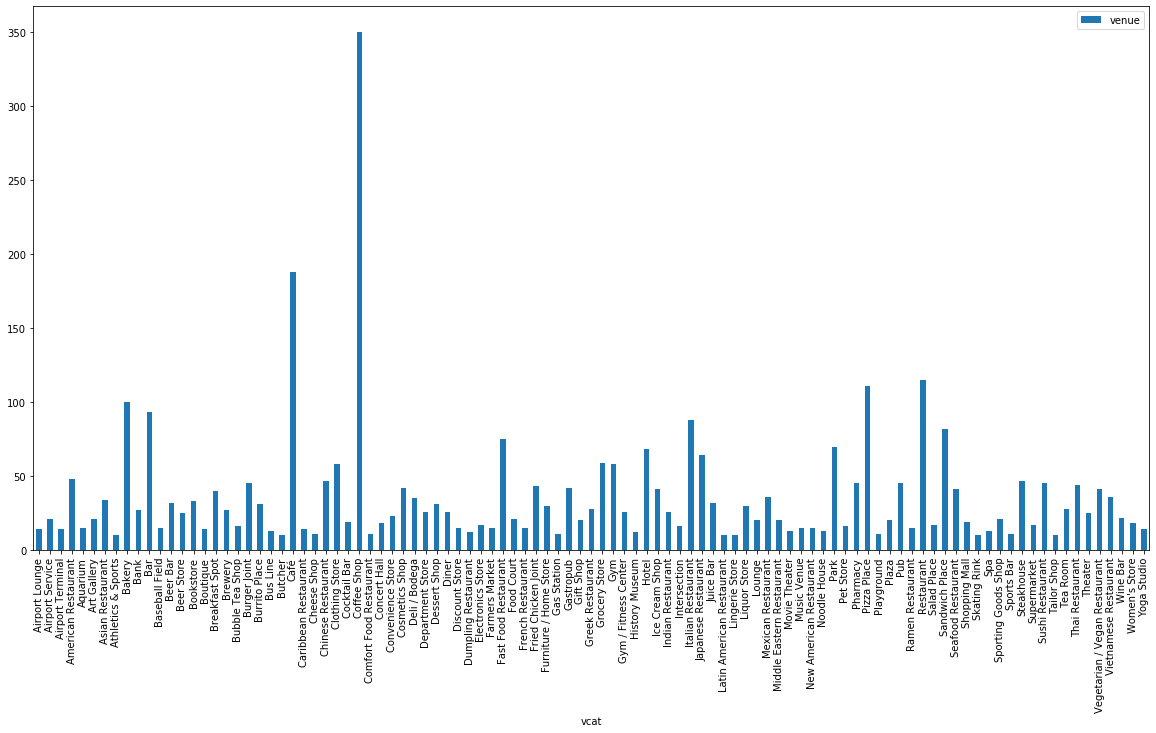

In [48]:
to_vcat_grp = to_venues[['vcat','venue']].groupby(by='vcat').count()
to_vcat_grp[to_vcat_grp['venue']>=10].plot(kind='bar', figsize=[20, 10])

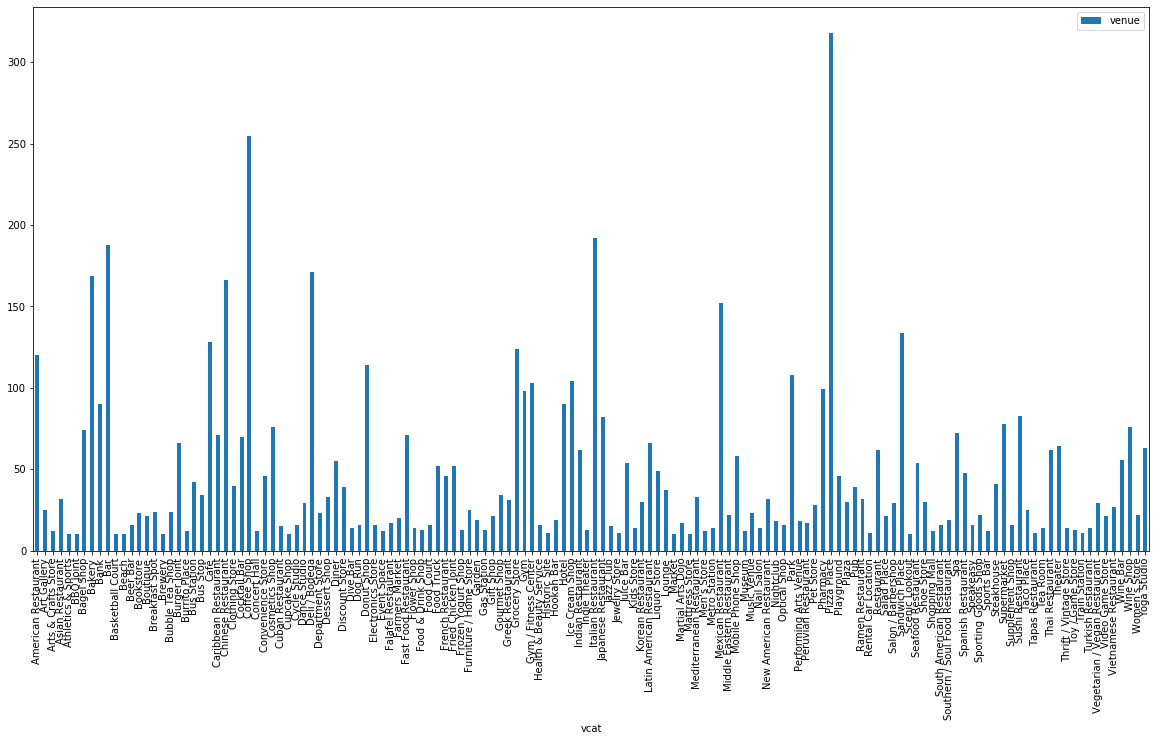

In [49]:
ny_vcat_grp = ny_venues[['vcat','venue']].groupby(by='vcat').count()
ny_vcat_grp[ny_vcat_grp['venue']>=10].plot(kind='bar', figsize=[20, 10])

#### As seen in the above plots, there are several venues exists in both Toronto and New York....and of course there are more venues in NY than TO. lets expore the data further in the next section

### 3. Data Preparation

In [50]:
categories = ny_venues.vcat.value_counts()

##### We are interested to know only the food realted venues. so lets prepare a list that might potentially be a restaurant

In [51]:
restaurant_and_related = ['Pizza','Coffe', 'Restaurant', 'Food', 'Dessert','Breakfast','Bakery'\
                          ,'Chocolate','Cafe','Fried Chicken', 'Sandwich','Diner'\
                          ,'Burger','Salad','Burrito','Ice Cream']

In [52]:
#create a function to perform the filter
def get_only_restaurants(df, restaurant_and_related):
    venues_filtered = pd.DataFrame()
    for i in range(0,len(restaurant_and_related)):
        venues_filtered = venues_filtered.append(df[df['vcat'].str.contains(restaurant_and_related[i])])
    venues_filtered.drop_duplicates(inplace=True)
    return venues_filtered

In [53]:
to_venues_filtered = get_only_restaurants(to_venues, restaurant_and_related)

In [54]:
to_venues_filtered.shape

(1008, 9)

##### Lets filter the venues of our interests as listed above

In [55]:
ny_venues_filtered = get_only_restaurants(ny_venues, restaurant_and_related)

In [56]:
ny_venues_filtered.shape

(3238, 9)

In [57]:
ny_venues_filtered['set']='NY'
to_venues_filtered['set']='TO'

In [58]:
to_venues_filtered.head()

,neighbourhood,postcode,borough,lat,lng,venue,vlat,vlng,vcat,set
7,Victoria Village,M4A,North York,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place,TO
127,"Woodbine Gardens, Parkview Hill",M4B,East York,43.706397,-79.309937,Pizza Pizza,43.705159,-79.313130,Pizza Place,TO
131,"Woodbine Gardens, Parkview Hill",M4B,East York,43.706397,-79.309937,Venice Pizza,43.705921,-79.313957,Pizza Place,TO
149,"Ryerson, Garden District",M5B,Downtown Toronto,43.657162,-79.378937,Blaze Pizza,43.656518,-79.380015,Pizza Place,TO
216,"Ryerson, Garden District",M5B,Downtown Toronto,43.657162,-79.378937,Panago,43.658258,-79.384313,Pizza Place,TO


##### Lets combine the venues for further analysis

In [59]:
venues_combined = ny_venues_filtered[['set','vcat','venue','lat','lng','vlat','vlng']]

In [60]:
venues_combined = venues_combined.append(to_venues_filtered[['set','vcat','venue','lat','lng','vlat','vlng']])

In [61]:
venues_combined.set.value_counts()

NY    3238
TO    1008
Name: set, dtype: int64

In [62]:
venues_combined.head()

,set,vcat,venue,lat,lng,vlat,vlng
1,NY,Pizza Place,New York Pizza Suprema,40.750742,-73.99653,40.750124,-73.994992
80,NY,Pizza Place,Lombardi’s,40.750742,-73.99653,40.746347,-73.997612
116,NY,Pizza Place,Champion Pizza - Ludlow,40.717040,-73.98700,40.719190,-73.988850
157,NY,Pizza Place,Champion Pizza,40.717040,-73.98700,40.719722,-73.987655
203,NY,Pizza Place,Joe's Pizza,40.732509,-73.98935,40.733234,-73.987672


In [63]:
venues_combined.reset_index(drop=True, inplace=True)

In [64]:
venues_combined.head()

,set,vcat,venue,lat,lng,vlat,vlng
0,NY,Pizza Place,New York Pizza Suprema,40.750742,-73.99653,40.750124,-73.994992
1,NY,Pizza Place,Lombardi’s,40.750742,-73.99653,40.746347,-73.997612
2,NY,Pizza Place,Champion Pizza - Ludlow,40.717040,-73.98700,40.719190,-73.988850
3,NY,Pizza Place,Champion Pizza,40.717040,-73.98700,40.719722,-73.987655
4,NY,Pizza Place,Joe's Pizza,40.732509,-73.98935,40.733234,-73.987672


##### Lets look at the options available in both the sides

In [65]:
ny_vcat = ny_venues_filtered['vcat'].unique()

In [133]:
print ('Count of distinct cuisine types in New York :' ,len(ny_vcat))

Count of distinct cuisine types in New York : 105


In [67]:
to_vcat = to_venues_filtered['vcat'].unique()

In [134]:
print ('Count of distinct cuisine types in New York :' ,len(to_vcat))

Count of distinct cuisine types in New York : 70


In [69]:
only_ny = set(ny_vcat) - set(to_vcat)

In [70]:
only_ny

{'African Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'Cantonese Restaurant',
 'Caucasian Restaurant',
 'College Cafeteria',
 'Czech Restaurant',
 'Halal Restaurant',
 'Hawaiian Restaurant',
 'Israeli Restaurant',
 'Japanese Curry Restaurant',
 'Jewish Restaurant',
 'Kebab Restaurant',
 'Kosher Restaurant',
 'Lebanese Restaurant',
 'Malay Restaurant',
 'Moroccan Restaurant',
 'North Indian Restaurant',
 'Paella Restaurant',
 'Pakistani Restaurant',
 'Peking Duck Restaurant',
 'Persian Restaurant',
 'Peruvian Restaurant',
 'Russian Restaurant',
 'Salvadoran Restaurant',
 'Scandinavian Restaurant',
 'Shanghai Restaurant',
 'Soba Restaurant',
 'South American Restaurant',
 'South Indian Restaurant',
 'Spanish Restaurant',
 'Swiss Restaurant',
 'Szechuan Restaurant',
 'Tapas Restaurant',
 'Tex-Mex Restaurant',
 'Tibetan Restaurant',
 'Turkish Restaurant',
 'Udon Restaurant',
 'Venezuelan Restaurant'}

In [137]:
len(only_ny)

41

In [72]:
only_to = set(to_vcat) - set(ny_vcat)

In [73]:
only_to

{'Airport Food Court',
 'Belgian Restaurant',
 'Comfort Food Restaurant',
 'Doner Restaurant',
 'Gaming Cafe',
 'Hakka Restaurant'}

In [74]:
len(only_to)

6

#### Comparing New York and Toronto, there are 41 cuisines exists in NY that are not in Toronto, whereas only 6 cuisines exist in Toronto that are not in New York.

In [75]:
common_cats = set(ny_vcat) & set(to_vcat)

In [76]:
common_cats

{'Afghan Restaurant',
 'American Restaurant',
 'Asian Restaurant',
 'Bakery',
 'Bed & Breakfast',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Burger Joint',
 'Burrito Place',
 'Cafeteria',
 'Cajun / Creole Restaurant',
 'Caribbean Restaurant',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Coffee Shop',
 'Colombian Restaurant',
 'Cuban Restaurant',
 'Dessert Shop',
 'Dim Sum Restaurant',
 'Diner',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Empanada Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'Food',
 'Food & Drink Shop',
 'Food Court',
 'Food Truck',
 'French Restaurant',
 'Fried Chicken Joint',
 'German Restaurant',
 'Gluten-free Restaurant',
 'Greek Restaurant',
 'Health Food Store',
 'Ice Cream Shop',
 'Indian Restaurant',
 'Indonesian Restaurant',
 'Italian Restaurant',
 'Japanese Restaurant',
 'Korean Restaurant',
 'Latin American Restaurant',
 'Mediterranean Restaurant',
 'Mexican Restaurant',
 'Midd

### Lets check the Word Clouds

#### Define the Word Cloud function

In [77]:
def wc(venue_list):
    # instantiate a word cloud object
    wc = WordCloud(
        background_color='white',
        max_words=2000,
        stopwords = {'Restaurant'}
    )
    refined_str = ' '.join([str(i).replace('Restaurant','',1).rstrip().replace(' ','_',1) for i in list(venue_list)])
    # generate the word cloud
    wc.generate(refined_str)
    return wc

#### Lets check the Word Cloud of Restaurante that are in NY but not in TO

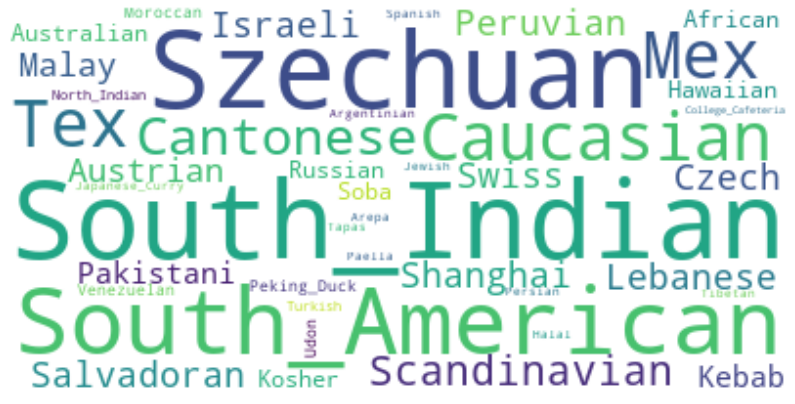

In [78]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
ny_wc = wc(only_ny)
plt.imshow(ny_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Lets check the Word Cloud of Restaurante that are in TO but not in NY

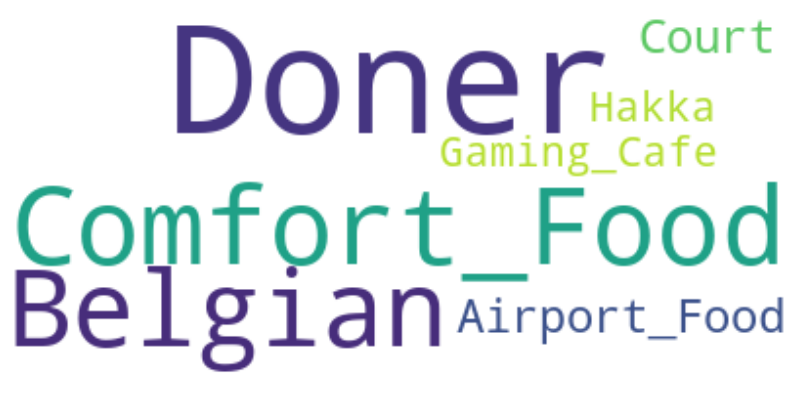

In [79]:
fig = plt.figure(figsize=[20,12])
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
to_wc = wc(only_to)
plt.imshow(to_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### To get more insight, lets take a look at the ethinic origin population in Toronto as of 2016. The data is sourced from wiki page - https://en.wikipedia.org/wiki/Demographics_of_Toronto

In [80]:
ethinic = pd.read_csv('toronto ethinic population.csv')

In [81]:
ethinic.head()

,Top 20 Ethnic origins in the City of Toronto,Population_2016,Percentage
0,Chinese,332830,13
1,English,331890,12
2,Canadian,323175,12
3,Irish,262965,10
4,Scottish,256250,10


In [82]:
ethinic.rename(columns={'Top 20 Ethnic origins in the City of Toronto':'ethinic origin'}, inplace=True)

In [83]:
ethinic['ethinic origin'].tolist()

['Chinese',
 'English',
 'Canadian',
 'Irish',
 'Scottish',
 'East Indian',
 'Italian',
 'Filipino',
 'German',
 'French',
 'Polish',
 'Portuguese',
 'Jamaican',
 'Russian',
 'Ukrainian',
 'Sri Lankan',
 'Greek',
 'Spanish',
 'British Isles origins (other)',
 'Iranian']

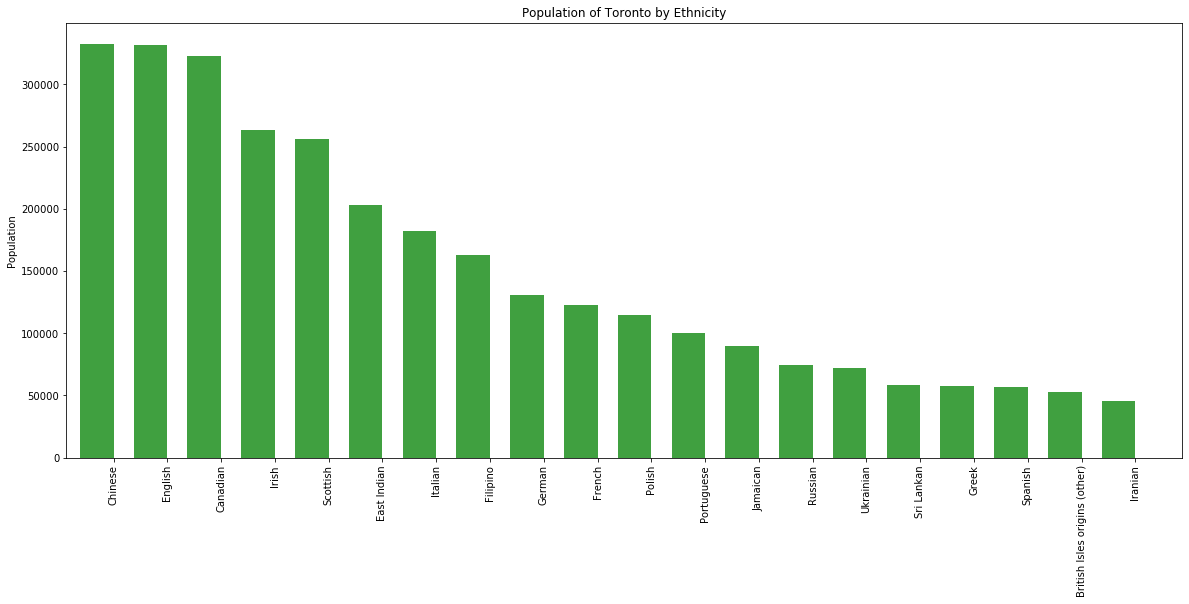

In [128]:
ethinics = ethinic['ethinic origin'].tolist()
ethinic.plot(kind='bar', figsize=[20,8], width=1.25, legend=[], color='g', title = 'Population of Toronto by Ethnicity', alpha=0.75)
plt.ylabel('Population')
plt.xticks(range(len(ethinics)),ethinics)
plt.show()

In [85]:
df_only_ny = pd.DataFrame(only_ny, columns={'ethinics'})
df_only_ny.reset_index(drop=True, inplace=True)

In [86]:
df_only_ny.head()

,ethinics
0,South Indian Restaurant
1,Szechuan Restaurant
2,South American Restaurant
3,Caucasian Restaurant
4,Tex-Mex Restaurant


In [87]:
missing_cuisine_types=[]
for i in ethinics:
    x = df_only_ny[df_only_ny['ethinics'].str.contains(i)]['ethinics'].tolist()
    if x:
        missing_cuisine_types.extend(x)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


#### The following cusinies may not be available widely so promising to be explorable

In [88]:
missing_cuisine_types

['Russian Restaurant', 'Spanish Restaurant']

### 4. Methodology

#### The problem we are dealing with requires to understand the geographical clustering of the restaurant/cuisine within the neighbourhoods of our areas of interest. Lets transform the data that we have prepared and find the number of occurances of each category of the restaurant type. Then we can apply clustering technique KMeans to tag the neighbourhood and plot it on a map. This will give a good visual of the clustering.

In [89]:
venues_combined.head()

,set,vcat,venue,lat,lng,vlat,vlng
0,NY,Pizza Place,New York Pizza Suprema,40.750742,-73.99653,40.750124,-73.994992
1,NY,Pizza Place,Lombardi’s,40.750742,-73.99653,40.746347,-73.997612
2,NY,Pizza Place,Champion Pizza - Ludlow,40.717040,-73.98700,40.719190,-73.988850
3,NY,Pizza Place,Champion Pizza,40.717040,-73.98700,40.719722,-73.987655
4,NY,Pizza Place,Joe's Pizza,40.732509,-73.98935,40.733234,-73.987672


In [90]:
venues_combined['latlng']=venues_combined.lat.map(str)+':'+venues_combined.lng.map(str)



In [91]:
venues_combined.head()

,set,vcat,venue,lat,lng,vlat,vlng,latlng
0,NY,Pizza Place,New York Pizza Suprema,40.750742,-73.99653,40.750124,-73.994992,40.750741999999995:-73.99653
1,NY,Pizza Place,Lombardi’s,40.750742,-73.99653,40.746347,-73.997612,40.750741999999995:-73.99653
2,NY,Pizza Place,Champion Pizza - Ludlow,40.717040,-73.98700,40.719190,-73.988850,40.717040000000004:-73.987
3,NY,Pizza Place,Champion Pizza,40.717040,-73.98700,40.719722,-73.987655,40.717040000000004:-73.987
4,NY,Pizza Place,Joe's Pizza,40.732509,-73.98935,40.733234,-73.987672,40.732509:-73.98935


In [92]:
ven_temp = venues_combined[['latlng','set','vcat','venue']].groupby(by=['latlng','set','vcat']).count()

In [93]:
ven_temp.head()

venue
latlng              set vcat                     
40.508274:-74.24387 NY  Bakery                  1
                        Chinese Restaurant      1
                        Ice Cream Shop          1
                        Italian Restaurant      5
                        Pizza Place             1

In [94]:
ven_temp = ven_temp.reset_index(level=[0,1,2])


In [95]:
ven_temp.drop(columns={'venue'}, inplace=True)

In [96]:
ven_temp.head()

,latlng,set,vcat
0,40.508274:-74.24387,NY,Bakery
1,40.508274:-74.24387,NY,Chinese Restaurant
2,40.508274:-74.24387,NY,Ice Cream Shop
3,40.508274:-74.24387,NY,Italian Restaurant
4,40.508274:-74.24387,NY,Pizza Place


In [97]:
ven_temp.set_index(['latlng','set'], inplace=True)

In [98]:
ven_temp.head()

vcat
latlng              set                    
40.508274:-74.24387 NY               Bakery
                    NY   Chinese Restaurant
                    NY       Ice Cream Shop
                    NY   Italian Restaurant
                    NY          Pizza Place

In [99]:
venue_trans = pd.get_dummies(ven_temp['vcat'])

In [100]:
venue_trans.head()

Afghan Restaurant  African Restaurant  \
latlng              set                                          
40.508274:-74.24387 NY                   0                   0   
                    NY                   0                   0   
                    NY                   0                   0   
                    NY                   0                   0   
                    NY                   0                   0   

                         Airport Food Court  American Restaurant  \
latlng              set                                            
40.508274:-74.24387 NY                    0                    0   
                    NY                    0                    0   
                    NY                    0                    0   
                    NY                    0                    0   
                    NY                    0                    0   

                         Arepa Restaurant  Argentinian Restaurant  \
latlng              set                                             
40.508274:-74.24387 NY                  0                       0   
                    NY                  0                       0   
                    NY                  0                       0   
                    NY                  0                       0   
                    NY                  0                       0   

                         Asian Restaurant  Australian Restaurant  \
latlng              set                                            
40.508274:-74.24387 NY                  0                      0   
                    NY                  0                      0   
                    NY                  0                      0   
                    NY                  0                      0   
                    NY                  0                      0   

                         Austrian Restaurant  Bakery  ...  Tapas Restaurant  \
latlng              set                               ...                     
40.508274:-74.24387 NY                     0       1  ...                 0   
                    NY                     0       0  ...                 0   
                    NY                     0       0  ...                 0   
                    NY                     0       0  ...                 0   
                    NY                     0       0  ...                 0   

                         Tex-Mex Restaurant  Thai Restaurant  \
latlng              set                                        
40.508274:-74.24387 NY                    0                0   
                    NY                    0                0   
                    NY                    0                0   
                    NY                    0                0   
                    NY                    0                0   

                         Theme Restaurant  Tibetan Restaurant  \
latlng              set                                         
40.508274:-74.24387 NY                  0                   0   
                    NY                  0                   0   
                    NY                  0                   0   
                    NY                  0                   0   
                    NY                  0                   0   

                         Turkish Restaurant  Udon Restaurant  \
latlng              set                                        
40.508274:-74.24387 NY                    0                0   
                    NY                    0                0   
                    NY                    0                0   
                    NY                    0                0   
                    NY                    0                0   

                         Vegetarian / Vegan Restaurant  Venezuelan Restaurant  \
latlng              set                                                         
40.508274:-74.24387 NY                               0

In [101]:
venue_grouped = venue_trans.groupby(by=['latlng','set']).mean()

In [102]:
venue_grouped.head()

,,Afghan Restaurant,African Restaurant,Airport Food Court,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Bakery,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
latlng,set,,,,,,,,,,,,,,,,,,,,,
40.508274:-74.24387,NY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.543116999999995:-74.17628,NY,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.55135300000001:-74.15098,NY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.560167:-73.90890999999998,NY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.569394:-74.11785,NY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2


In [138]:
venue_grouped.shape

(250, 111)

#### Clustering using KMeans
##### Lets try with various k values and see how the clusturing is doing

In [104]:
from sklearn.cluster import KMeans
k=8

KMC = KMeans(n_clusters=k, random_state=1).fit(venue_grouped)

In [105]:
KMC.labels_

array([6, 6, 6, 4, 6, 0, 0, 6, 6, 7, 6, 6, 6, 6, 0, 0, 1, 6, 6, 6, 6, 6,
       6, 6, 6, 1, 6, 6, 0, 6, 6, 0, 6, 6, 6, 6, 6, 0, 6, 6, 6, 3, 0, 6,
       0, 6, 0, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 0, 6, 6, 6, 2, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4,
       6, 6, 6, 6, 6, 6, 1, 0, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 4, 6,
       6, 6, 5, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 0, 6, 6, 6, 2, 6, 6, 6, 1,
       6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 6, 6, 6, 1, 6, 6, 6, 6, 6,
       6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 3, 6, 6, 6, 1, 2, 6, 0, 6, 6, 6, 2, 6, 6, 6, 6, 6,
       6, 6, 6, 1, 6, 0, 5, 6, 1, 3, 6, 6, 6, 1, 0, 6, 1, 6, 3, 6, 6, 6,
       6, 6, 1, 0, 6, 6, 2, 2], dtype=int32)

In [106]:
venue_clustered = venue_grouped.copy()

In [107]:
venue_clustered.insert(0, 'cluster', KMC.labels_)

In [108]:
venue_clustered.head()

,,cluster,Afghan Restaurant,African Restaurant,Airport Food Court,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
latlng,set,,,,,,,,,,,,,,,,,,,,,
40.508274:-74.24387,NY,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.543116999999995:-74.17628,NY,6,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.55135300000001:-74.15098,NY,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.560167:-73.90890999999998,NY,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.569394:-74.11785,NY,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2


In [109]:
venue_clustered.reset_index(inplace=True)

In [110]:
venue_clustered[['lat','lng']] = venue_clustered['latlng'].str.split(':', n=1, expand=True)

In [111]:
venue_clustered['lat']= pd.to_numeric(venue_clustered['lat'])
venue_clustered['lng']= pd.to_numeric(venue_clustered['lng'])

In [112]:
venue_clustered.cluster.value_counts()

6    195
0     24
1     13
2      7
3      4
4      3
7      2
5      2
Name: cluster, dtype: int64

In [113]:
venue_clustered.head()

,latlng,set,cluster,Afghan Restaurant,African Restaurant,Airport Food Court,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,...,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,lat,lng
0,40.508274:-74.24387,NY,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.508274,-74.24387
1,40.543116999999995:-74.17628,NY,6,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.543117,-74.17628
2,40.55135300000001:-74.15098,NY,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.551353,-74.15098
3,40.560167:-73.90890999999998,NY,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.560167,-73.90891
4,40.569394:-74.11785,NY,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,40.569394,-74.11785


#### Put together the results on the Map

In [119]:
#initial lat and lng for TO
latitude = 43.651070 
longitude = -79.347015 
init_latlng = [latitude, longitude]
print('Toranto lat and lng - {}, {}.'.format(init_latlng[0], init_latlng[1]))

Toranto lat and lng - 43.65107, -79.347015.


#### Look at the map of Toronto

In [115]:
#initial lat and lng for TO
latitude = 43.651070 
longitude = -79.347015 
init_latlng = [latitude, longitude]
print('Toranto lat and lng : {}, {}.'.format(init_latlng[0], init_latlng[1]))

Toranto lat and lng : 43.65107, -79.347015.


In [132]:
    df=venue_clustered[venue_clustered['set']=='TO']
    latitude = init_latlng[0] 
    longitude = init_latlng[1] 
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

    # set color scheme for the clusters
    x = np.arange(k)
    ys = [i + x + (i*x)**2 for i in range(k)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    for index, row in df.iterrows():
        lat = row['lat']
        lng = row['lng']
        cluster = row['cluster']
        
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color=rainbow[cluster],
            fill=False,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(map_clusters)
    map_clusters

#### Look at the map of New York

In [117]:
#initial lat and lng for NY
latitude = 40.7128 
longitude = -74.0060 
init_latlng = [latitude, longitude]
print('New York lat and lng : {}, {}.'.format(init_latlng[0], init_latlng[1]))

New York lat and lng : 40.7128, -74.006.


In [118]:
    df=venue_clustered[venue_clustered['set']=='NY']
    latitude = init_latlng[0] 
    longitude = init_latlng[1] 
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

    # set color scheme for the clusters
    x = np.arange(k)
    ys = [i + x + (i*x)**2 for i in range(k)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    for index, row in df.iterrows():
        lat = row['lat']
        lng = row['lng']
        cluster = row['cluster']
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color=rainbow[cluster],
            fill=False,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(map_clusters)
    map_clusters